<a href="https://colab.research.google.com/github/dannynacker/strobe_depression/blob/main/wp2_adjustments.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

intervention; adjusted initial wash ramp (max duty cycle + decay into strobe) and played with dark phase length extension / occasional wash light intrusion

Generated STP file: stp_sequence/z_intervention_adj2.txt
Saved plot: plots/z_intervention_adj2_plot.png
Exported OSC1–2 full CSV → plots/z_intervention_adj2_osc12_full.csv


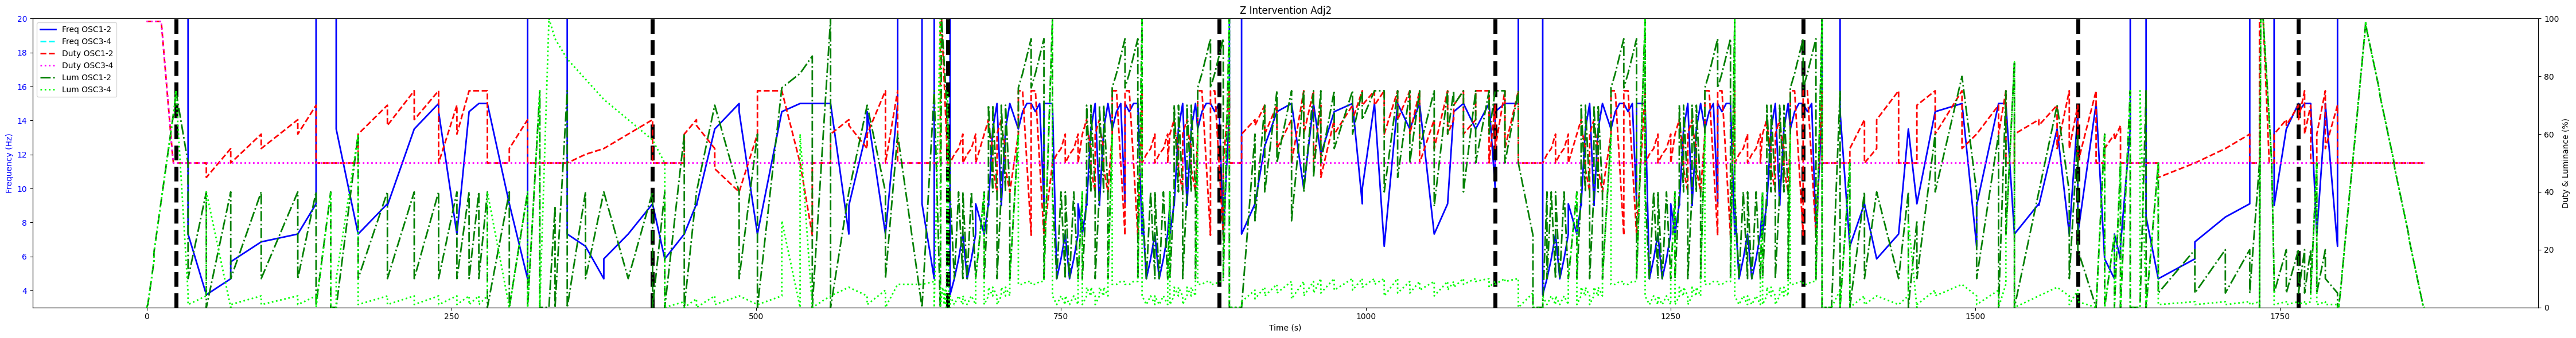

In [9]:
import os
import matplotlib.pyplot as plt
import numpy as np

# -----------------------------------------------------------
# Basic Formatting Functions
# -----------------------------------------------------------
def format_time(total_seconds):
    """Format total seconds as hh:mm:ss.s with leading zeros."""
    minutes = int(total_seconds // 60)
    seconds = int(total_seconds % 60)
    fraction = total_seconds - int(total_seconds)
    return f"00:{minutes:02}:{seconds:02}.{int(fraction * 10)}"

def get_led_assignments():
    """
    Return unique LED assignments:
      OSC1: [1,0,0,0]
      OSC2: [0,1,0,0]
      OSC3: [0,0,1,0]
      OSC4: [0,0,0,1]
    """
    return [[1,0,0,0], [0,1,0,0], [0,0,1,0], [0,0,0,1]]

def format_stp_dual(step_duration, wave_type, freq12, duty12, lum12, freq34, duty34, lum34):
    """
    Format an STP line for dual-group sequences.
    Each parameter is a 2-element list.
    """
    led_assignments = get_led_assignments()
    blocks = []
    # OSC1 and OSC2 use the OSC12 parameters.
    for osc in range(2):
        block = (f"{wave_type},"
                 f"{freq12[0]:.2f},{freq12[1]:.2f},"
                 f"{round(duty12[0])},{round(duty12[1])},"
                 f"{','.join(map(str, led_assignments[osc]))},"
                 f"{round(lum12[0])},{round(lum12[1])}")
        blocks.append(block)
    # OSC3 and OSC4 use the OSC34 parameters.
    for osc in range(2,4):
        block = (f"{wave_type},"
                 f"{freq34[0]:.2f},{freq34[1]:.2f},"
                 f"{round(duty34[0])},{round(duty34[1])},"
                 f"{','.join(map(str, led_assignments[osc]))},"
                 f"{round(lum34[0])},{round(lum34[1])}")
        blocks.append(block)
    return f"STP\"{max(step_duration, 0.1):.1f},{','.join(blocks)}\""

def create_time_series(durations, pairs):
    """
    Given a list of step durations and corresponding [start, end] pairs,
    return a list of time points and values (linear interpolation).
    """
    times = []
    values = []
    current_time = 0
    for d, pair in zip(durations, pairs):
        times.append(current_time)
        values.append(pair[0])
        current_time += d
        times.append(current_time)
        values.append(pair[1])
    return times, values

# -----------------------------------------------------------
# Sequence Parameters for a Single Sequence
# -----------------------------------------------------------

sequence = {
  "durations": [
    # Warmup - 0:00 to 0:24
    1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
    # Segment A - 127 seconds. 0:24 to 2:31
    10, 15, 20, 25, 30, 15, 12,
    # dark phase (extended from 2 to 4.5) - 2:31 to 2:35.5
    4.5,
    # rest of Segment A - 167 seconds. 2:35.5 to 5:22.5
    18, 24, 22, 20, 15, 10, 8, 7, 18, 15, 10,
    # interim dark phase (extended from 3 to 7.5) - 5:22.5 to 5:30
    7.5,
    # Segment B - 321 seconds. 5:30 to 10:51
    5, 10, 15, 15, 20, 20, 10, 16, 10, 15, 20, 15, 20, 15, 10, 15, 15, 15, 15, 10, 20, 10, 5,
    # interim wash phase - swapped from interim dark phase of 3 seconds to wash phase of 8 seconds - 10:51 to 10:59
    1, 1, 1, 1, 1, 1, 1, 1,
    # Segment C1 - 229.1 seconds + made final step last 5 seconds (+3.2s). 10:59 to 15:48.1
    3.5, 3.5, 3.5, 3.5, 3.5, 3.5, 7, 3.5, 3.5, 3.5, 3.5, 3.5, 3.5, 7, 3.5, 3.5, 3.5, 3.5, 3.5, 3.5, 7,
    3.5, 3.5, 3.5, 3.5, 3.5, 3.5, 3.5, 3.5, 3.5, 3.5, 3.5, 3.5, 3.5, 3.5, 3.5, 3.5, 3.5, 3.5, 3.5, 3.5, 3.5,
    3.5, 3.5, 3.5, 3.5, 3.5, 3.5, 1.8, 3.5, 3.5, 3.5, 3.5, 3.5, 3.5, 1.8, 3.5, 3.5, 3.5, 3.5, 3.5, 3.5, 5,
    # interim dark phase (extended from 5 to 10) - 15:48.1 to 15:58.1
    10,
    # Peak Segment - 239 seconds. 15:58.1 to 19:57.1
    11, 8, 10, 12, 10, 8, 6, 11, 15, 8, 10, 8, 11, 10, 8, 12, 11, 5, 8, 10, 11, 5, 8, 11, 12,
    # interim dark phase (extended from 5 to 8) - 19:57.1 to 20:05.1
    8,
    # Segment C2 - 229.1 seconds + made final step last 5 seconds (+3.2s). 20:05.1 to 23:49.2
    3.5, 3.5, 3.5, 3.5, 3.5, 3.5, 7, 3.5, 3.5, 3.5, 3.5, 3.5, 3.5, 7, 3.5, 3.5, 3.5, 3.5, 3.5, 3.5, 7,
    3.5, 3.5, 3.5, 3.5, 3.5, 3.5, 3.5, 3.5, 3.5, 3.5, 3.5, 3.5, 3.5, 3.5, 3.5, 3.5, 3.5, 3.5, 3.5, 3.5, 3.5,
    3.5, 3.5, 3.5, 3.5, 3.5, 3.5, 1.8, 3.5, 3.5, 3.5, 3.5, 3.5, 3.5, 1.8, 3.5, 3.5, 3.5, 3.5, 3.5, 3.5, 5,
    # interim dark phase (extended from 3 to 7.8) - 23:49.2 to 23:57
    7.8,
    # Segment D - 245 seconds. 23:57 to 28:02
    7, 8, 12, 10, 18, 8, 7, 15, 22, 12, 18, 6, 7, 20, 15, 10, 7, 15, 7, 8, 5, 8,
    # interim dark phase (extended from 3 to 8). 28:02 to 28:10
    8,
    # Segment E - 98 seconds. 28:10 to 29:48.
    5, 10, 30, 25, 20, 8,
    # interim wash phase - swapped from interim dark phase of 2 seconds to wash phase of 12 seconds - 29:48 to 30:00
    1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
    # rest of Segment E - 52 seconds. 30:00 to 30:52
    10, 10, 5, 5, 5, 7, 10,
    # Cooldown (71 items) - 71.3 seconds. 30:52 to 32:03.3
    1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
    1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
    1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1.3
  ],
  "freqs_osc12": [
    # Warmup (24 items)
    [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60],
    [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60],
    # Segment A (18 items) + 1 dark phase
    [60, 60], [7.32, 3.75], [3.75, 4.69], [5.69, 6.86], [6.86, 7.32], [7.32, 9.1],
    [60, 60],
    [60, 60], # dark phase
    [13.5, 7.32], [7.32, 9.1], [9, 13.5], [13.5, 15], [14.52, 7.32],
    [7.32, 14.52], [14.52, 15], [15, 15], [15, 9.1], [9.1, 4.69], [60, 60],
    [60, 60], # interim dark phase
    # Segment B (23 items)
    [60, 60], [60, 60], [7.32, 6.6], [6.6, 4.69], [5.86, 7.32], [7.32, 9.1], [9.1, 5.86], [5.86, 7.32],
    [7.32, 9.1], [9, 13.5], [13.5, 15], [14.52, 7.32], [7.32, 14.52], [14.52, 15], [15, 15], [15, 15],
    [15, 7.32], [9, 13.5], [14.52, 7.32], [7.32, 15], [60, 60], [9.1, 4.69], [60, 60],
    # Interim wash phase (8 items)
    [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60],
    # Segment C1 (63 items)
    [3.75, 4.69], [4.69, 5.86], [5.86, 7.32], [7.32, 4.69], [4.69, 5.86], [5.86, 7.32], [9.1, 7.32],
    [7.32, 9.1], [9, 13.5], [13.5, 15], [15, 9.1], [9, 13.5], [13.5, 15], [15, 13.5],
    [13.5, 14.52], [14.52, 15], [15, 15], [15, 14.52], [14.52, 15], [15, 9.1], [15, 15],
    [15, 4.69], [4.69, 5.86], [5.86, 7.32], [7.32, 4.69], [4.69, 5.86], [5.86, 7.32], [9.1, 7.32],
    [7.32, 9.1], [9, 13.5], [13.5, 15], [15, 9.1], [9, 13.5], [13.5, 15], [15, 13.5],
    [13.5, 14.52], [14.52, 15], [15, 9.1], [15, 14.52], [14.52, 15], [15, 15], [15, 7.32],
    [9, 4.69], [4.69, 5.86], [5.86, 7.32], [7.32, 4.69], [4.69, 5.86], [5.86, 7.32], [7.32, 9.1],
    [7.32, 9.1], [9, 13.5], [13.5, 15], [15, 9.1], [9, 13.5], [13.5, 15], [15, 13.5],
    [13.5, 14.52], [14.52, 15], [15, 15], [15, 14.52], [14.52, 15], [15, 7.32], [7.32, 14.52],
    [60, 60], # interim dark phase
    # Peak Segment (25 items)
    [7.32, 9.1], [9.1, 12.5], [12.5, 14.52], [14.52, 15], [15, 10], [10, 15], [15, 12],
    [12, 14.52], [14.52, 15], [15, 9.1], [10, 15], [15, 6.6], [6.6, 15],
    [15, 13.5], [13.5, 15], [15, 7.32], [7.32, 9.1], [9.1, 14.52], [14.52, 15],
    [15, 13.5], [13.5, 15], [15, 10], [14.52, 15], [15, 15], [60, 60],
    [60, 60], # interim dark phase
    # Segment C2 (63 items)
    [3.75, 4.69], [4.69, 5.86], [5.86, 7.32], [7.32, 4.69], [4.69, 5.86], [5.86, 7.32], [9.1, 7.32],
    [7.32, 9.1], [9, 13.5], [13.5, 15], [15, 9.1], [9, 13.5], [13.5, 15], [15, 13.5],
    [13.5, 14.52], [14.52, 15], [15, 15], [15, 14.52], [14.52, 15], [15, 9.1], [15, 15],
    [15, 4.69], [4.69, 5.86], [5.86, 7.32], [7.32, 4.69], [4.69, 5.86], [5.86, 7.32], [9.1, 7.32],
    [7.32, 9.1], [9, 13.5], [13.5, 15], [15, 9.1], [9, 13.5], [13.5, 15], [15, 13.5],
    [13.5, 14.52], [14.52, 15], [15, 9.1], [15, 14.52], [14.52, 15], [15, 15], [15, 7.32],
    [9, 4.69], [4.69, 5.86], [5.86, 7.32], [7.32, 4.69], [4.69, 5.86], [5.86, 7.32], [7.32, 9.1],
    [7.32, 9.1], [9, 13.5], [13.5, 15], [15, 9.1], [9, 13.5], [13.5, 15], [15, 13.5],
    [13.5, 14.52], [14.52, 15], [15, 15], [15, 14.52], [14.52, 15], [15, 7.32], [7.32, 14.52],
    [60, 60], # interim dark phase
    # Segment D (22 items)
    [60, 60], [14.52, 6.6], [6.6, 9.1], [9.1, 5.86], [5.86, 7.32], [7.32, 13.5], [13.5, 9.1],
    [9.1, 14.52], [14.52, 15], [15, 6.6], [9, 15], [15, 15], [15, 7.32], [7.32, 9.1],
    [9, 13.5], [13.5, 7.32], [7.32, 14.52], [7.32, 15], [15, 5.86], [5.86, 4.69], [7.32, 5.86], [6.6, 13.5],
    [60, 60], # interim dark phase
    # Segment E (13 items total) + 1 wash phase of 12 steps
    [60, 60], [8.32, 4.69], [4.69, 5.86], [6.86, 8.32], [8.32, 9.1], [60, 60],
    # Interim wash phase (12 items)
    [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60],
    # Rest of Segment E
    [9, 13.5], [13.5, 15], [14.52, 15], [15, 15], [15, 7.32], [7.32, 14.52], [15, 6.6],
    # Cooldown (71 items)
    [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60],
    [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60],
    [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60],
    [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60],
    [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60],
    [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60]
  ],
  "duties_osc12": [
    # Warmup (24 items)
    [99, 99], [99, 99], [99, 99], [99, 99], [99, 99], [99, 99], [99, 99], [99, 99], [99, 99], [99, 99], [99, 99], [99, 99],
    [99, 94], [94, 89], [89, 84], [84, 79], [79, 74], [74, 69], [69, 64], [64, 59], [59, 54], [54, 50], [50, 50], [50, 50],
    # Segment A (18 items) + 1 dark phase
    [50, 50], [50, 50], [45, 55], [50, 60], [55, 65], [60, 70],
    [50, 50],
    [50, 50], # dark phase
    [50, 50], [60, 70], [63, 75], [65, 75], [50, 70],
    [60, 75], [75, 75], [75, 75], [50, 50], [55, 65], [50, 50],
    [50, 50], # interim dark phase
    # Segment B (23 items)
    [50, 50], [50, 50], [50, 53], [53, 55], [55, 60], [60, 65], [50, 50], [50, 50],
    [60, 65], [63, 55], [48, 40], [40, 60], [75, 75], [75, 50], [50, 25], [50, 50],
    [60, 65], [63, 55], [60, 75], [50, 75], [50, 50], [50, 50], [50, 50],
    # Interim wash phase (8 items)
    [100, 100], [100, 90], [90, 80], [80, 70], [70, 60], [60, 50], [50, 50], [50, 50],
    # Segment C1 (63 items)
    [50, 53], [53, 55], [55, 60], [50, 53], [53, 55], [55, 60], [50, 60],
    [60, 65], [63, 55], [48, 40], [60, 65], [63, 55], [48, 40], [40, 60],
    [75, 75], [75, 50], [50, 25], [75, 75], [75, 50], [50, 25], [25, 50],
    [50, 53], [53, 55], [55, 60], [50, 53], [53, 55], [55, 60], [50, 60],
    [60, 65], [63, 55], [48, 40], [60, 65], [63, 55], [48, 40], [40, 60],
    [75, 75], [75, 50], [50, 25], [75, 75], [75, 50], [50, 25], [25, 75],
    [50, 53], [53, 55], [55, 60], [50, 53], [53, 55], [55, 60], [50, 60],
    [60, 65], [63, 55], [48, 40], [60, 65], [63, 55], [48, 40], [40, 60],
    [75, 75], [75, 50], [50, 25], [75, 75], [75, 50], [50, 25], [50, 75],
    [50, 50], # interim dark phase
    # Peak Segment (25 items)
    [60, 65], [63, 70], [60, 70], [55, 65], [50, 75], [60, 75], [50, 70],
    [45, 65], [60, 70], [65, 75], [70, 75], [70, 75], [60, 75],
    [65, 75], [60, 75], [50, 65], [55, 75], [60, 65], [70, 75],
    [60, 65], [75, 75], [50, 70], [55, 75], [55, 75], [50, 50],
    [50, 50], # interim dark phase
    # Segment C2 (63 items)
    [50, 53], [53, 55], [55, 60], [50, 53], [53, 55], [55, 60], [50, 60],
    [60, 65], [63, 55], [48, 40], [60, 65], [63, 55], [48, 40], [40, 60],
    [75, 75], [75, 50], [50, 25], [75, 75], [75, 50], [50, 25], [25, 75],
    [50, 53], [53, 55], [55, 60], [50, 53], [53, 55], [55, 60], [50, 60],
    [60, 65], [63, 55], [48, 40], [60, 65], [63, 55], [48, 40], [40, 60],
    [75, 75], [75, 50], [50, 25], [75, 75], [75, 50], [50, 25], [25, 75],
    [50, 53], [53, 55], [55, 60], [50, 53], [53, 55], [55, 60], [50, 60],
    [60, 65], [63, 55], [48, 40], [60, 65], [63, 55], [48, 40], [40, 60],
    [75, 75], [75, 50], [50, 25], [75, 75], [75, 50], [50, 25], [25, 75],
    [50, 50], # interim dark phase
    # Segment D (22 items)
    [50, 50], [50, 50], [55, 65], [50, 55], [65, 75], [50, 50], [50, 50],
    [70, 75], [60, 75], [55, 60], [60, 70], [60, 75], [50, 50], [60, 65],
    [63, 70], [55, 75], [55, 70], [50, 75], [50, 50], [55, 60], [58, 63], [50, 50],
    [50, 50], # interim dark phase
    # Segment E (13 items total) + 1 wash phase of 12 steps
    [50, 50], [50, 50], [45, 50], [50, 55], [55, 60], [50, 50],
    # Interim wash phase (12 items)
    [100, 100], [100, 100], [100, 100], [100, 90], [90, 80], [80, 70], [70, 60], [60, 50], [50, 50], [50, 50], [50, 50], [50, 50],
    # Rest of Segment E
    [60, 65], [63, 70], [65, 75], [60, 70], [50, 50], [60, 75], [55, 70],
    # Cooldown (71 items)
    [50, 50], [50, 50], [50, 50], [50, 50], [50, 50], [50, 50], [50, 50], [50, 50], [50, 50], [50, 50], [50, 50], [50, 50],
    [50, 50], [50, 50], [50, 50], [50, 50], [50, 50], [50, 50], [50, 50], [50, 50], [50, 50], [50, 50], [50, 50], [50, 50],
    [50, 50], [50, 50], [50, 50], [50, 50], [50, 50], [50, 50], [50, 50], [50, 50], [50, 50], [50, 50], [50, 50], [50, 50],
    [50, 50], [50, 50], [50, 50], [50, 50], [50, 50], [50, 50], [50, 50], [50, 50], [50, 50], [50, 50], [50, 50], [50, 50],
    [50, 50], [50, 50], [50, 50], [50, 50], [50, 50], [50, 50], [50, 50], [50, 50], [50, 50], [50, 50], [50, 50], [50, 50],
    [50, 50], [50, 50], [50, 50], [50, 50], [50, 50], [50, 50], [50, 50], [50, 50], [50, 50], [50, 50], [50, 50]
  ],
  "lums_osc12": [
    # Warmup (24 items)
    [0, 1], [1, 4], [4, 7], [7, 10], [10, 13], [13, 16], [19, 22], [22, 25], [25, 28], [28, 31], [31, 34], [34, 37],
    [37, 40], [40, 43], [43, 46], [46, 49], [49, 52], [52, 55], [55, 58], [58, 61], [61, 64], [64, 67], [67, 70], [70, 75],
    # Segment A (18 items) + 1 dark phase
    [75, 50],
    [10, 40], [0, 40], [10, 40], [10, 40], [10, 40], [1, 40],
    [0, 0], # dark phase
    [0, 60],
    [10, 40], [10, 40], [10, 40], [10, 40], [10, 40], [10, 40], [10, 40], [0, 40],
    [0, 40],
    [0, 75],
    [0, 0], # interim dark phase
    # Segment B (23 items)
    [0, 35], [0, 75],
    [0, 40], [10, 40], [40, 10], [10, 40], [0, 40], [0, 60],
    [0, 40], [40, 70], [70, 40], [10, 60], [0, 76], [76, 81], [81, 87], [0, 100],
    [0, 40], [40, 70], [70, 40], [10, 60], [60, 0],
    [0, 75], [75, 0],
    # Interim wash phase (8 items)
    [0, 100], [100, 93], [93, 86], [86, 79], [79, 72], [72, 65], [65, 58], [58, 50],
    # Segment C1 (63 items)
    [40, 10], [10, 40], [40, 10], [40, 10], [10, 40], [40, 10], [10, 40],
    [10, 40], [70, 40], [70, 40], [10, 40], [70, 40], [70, 40], [10, 60],
    [76, 81], [81, 87], [87, 93], [76, 81], [81, 87], [87, 93], [10, 100],
    [40, 10], [10, 40], [40, 10], [40, 10], [10, 40], [40, 10], [10, 40],
    [10, 40], [70, 40], [70, 40], [10, 40], [70, 40], [70, 40], [10, 60],
    [76, 81], [81, 87], [87, 93], [76, 81], [81, 87], [87, 93], [10, 100],
    [40, 10], [10, 40], [40, 10], [40, 10], [10, 40], [40, 10], [10, 40],
    [10, 40], [70, 40], [70, 40], [10, 40], [70, 40], [70, 40], [10, 60],
    [76, 81], [81, 87], [87, 93], [76, 81], [81, 87], [87, 93], [10, 100],
    [0, 0], # interim dark phase
    # Peak Segment (25 items)
    [0, 60], [30, 70], [40, 75], [50, 75], [30, 75], [40, 75], [45, 75],
    [50, 75], [55, 75], [60, 75], [65, 75], [75, 75], [40, 75],
    [45, 75], [50, 75], [55, 75], [35, 75], [60, 75], [70, 75],
    [40, 75], [50, 75], [60, 75], [75, 75], [50, 75], [50, 25],
    [0, 0], # interim dark phase
    # Segment C2 (63 items)
    [0, 40], [10, 40], [40, 10], [40, 10], [10, 40], [40, 10], [10, 40],
    [10, 40], [70, 40], [70, 40], [10, 40], [70, 40], [70, 40], [10, 60],
    [76, 81], [81, 87], [87, 93], [76, 81], [81, 87], [87, 93], [10, 100],
    [40, 10], [10, 40], [40, 10], [40, 10], [10, 40], [40, 10], [10, 40],
    [10, 40], [70, 40], [70, 40], [10, 40], [70, 40], [70, 40], [10, 60],
    [76, 81], [81, 87], [87, 93], [76, 81], [81, 87], [87, 93], [10, 100],
    [40, 10], [10, 40], [40, 10], [40, 10], [10, 40], [40, 10], [10, 40],
    [10, 40], [70, 40], [70, 40], [10, 40], [70, 40], [70, 40], [10, 60],
    [76, 81], [81, 87], [87, 93], [76, 81], [81, 87], [87, 93], [10, 100],
    [0, 0], # interim dark phase
    # Segment D (22 items)
    [0, 75], [0, 50], [0, 40], [10, 40], [40, 10], [10, 40], [0, 30],
    [10, 60], [40, 80], [80, 40], [10, 60], [0, 75], [25, 85],
    [0, 40], [40, 70], [70, 40], [10, 60], [20, 0], [0, 60],
    [0, 25], [0, 50], [0, 75],
    [0, 0], # interim dark phase
    # Segment E (13 items total) + 1 wash phase of 12 steps
    [0, 75],
    [0, 50], [5, 20], [5, 20], [5, 20], [5, 50],
    # Interim wash phase (12 items)
    [0, 100], [100, 100], [100, 100], [100, 93], [93, 86], [86, 79], [79, 72], [72, 65], [65, 58], [58, 50], [50, 30], [30, 10],
    # Rest of Segment E
    [5, 20], [5, 20], [5, 20], [5, 20], [5, 50], [5, 20],
    [10, 5],
    # Cooldown (71 items)
    [0, 1], [0, 4], [4, 8], [8, 13], [13, 17], [17, 22], [22, 26],
    [26, 31], [31, 35], [35, 40], [40, 44], [44, 48], [48, 53], [53, 57],
    [57, 62], [62, 66], [66, 71], [71, 75], [75, 80], [80, 84], [84, 89],
    [89, 93], [93, 98], [99, 96], [96, 94], [94, 92], [92, 90], [90, 88],
    [88, 86], [86, 84], [84, 82], [82, 80], [80, 78], [78, 76], [76, 73],
    [73, 71], [71, 69], [69, 67], [67, 65], [65, 63], [63, 61], [61, 59],
    [59, 57], [57, 55], [55, 53], [53, 51], [51, 48], [48, 46], [46, 44],
    [44, 42], [42, 40], [40, 38], [38, 36], [36, 34], [34, 32], [32, 30],
    [30, 28], [28, 26], [26, 23], [23, 21], [21, 19], [19, 17], [17, 15],
    [15, 13], [13, 11], [11, 9], [9, 7], [7, 5], [5, 3], [3, 1],
    [1, 0]
  ],
  "freqs_osc34": [
    # Warmup (24 items)
    [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60],
    [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60],
    # Segment A (18 items) + 1 dark phase
    [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60],
    [60, 60], # dark phase
    [60, 60], [60, 60],
    [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60],
    [60, 60], # interim dark phase
    # Segment B (23 items)
    [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60],
    [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60],
    [60, 60], [60, 60], [60, 60], [60, 60], [60, 60],
    # Interim wash phsae (8 items)
    [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60],
    # Segment C1 (63 items)
    [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60],
    [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60],
    [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60],
    [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60],
    [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60],
    [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60],
    [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60],
    [60, 60], # interim dark phase
    # Peak Segment (25 items)
    [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60],
    [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60],
    [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60],
    [60, 60], # interim dark phase
    # Segment C2 (63 items)
    [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60],
    [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60],
    [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60],
    [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60],
    [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60],
    [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60],
    [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60],
    [60, 60], # interim dark phase
    # Segment D (22 items)
    [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60],
    [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60],
    [60, 60], [60, 60], [60, 60], [60, 60],
    [60, 60], # interim dark phase
    # Segment E (13 items total) + 1 wash phase of 12 steps
    [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60],
    # Interim wash phase (12 items)
    [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60],
    # Rest of Segment E
    [60, 60], [60, 60], [60, 60],
    [60, 60], [60, 60], [60, 60], [60, 60],
    # Cooldown (71 items)
    [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60],
    [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60],
    [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60],
    [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60],
    [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60],
    [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60]
  ],
  "duties_osc34": [
    # All segments: each entry is [50,50] except for the initial wash ramp
    # Warmup (24 items)
    [99, 99], [99, 99], [99, 99], [99, 99], [99, 99], [99, 99], [99, 99], [99, 99], [99, 99], [99, 99], [99, 99], [99, 99],
    [99, 94], [94, 89], [89, 84], [84, 79], [79, 74], [74, 69], [69, 64], [64, 59], [59, 54], [54, 50], [50, 50], [50, 50],
    # Segment A (18 items) + 1 dark phase
    [50, 50], [50, 50], [50, 50], [50, 50], [50, 50], [50, 50], [50, 50],
    [50, 50], # dark phase
    [50, 50], [50, 50],
    [50, 50], [50, 50], [50, 50], [50, 50], [50, 50], [50, 50], [50, 50], [50, 50], [50, 50],
    [50, 50], # interim dark phase
    # Segment B (23 items)
    [50, 50], [50, 50], [50, 50], [50, 50], [50, 50], [50, 50], [50, 50], [50, 50], [50, 50],
    [50, 50], [50, 50], [50, 50], [50, 50], [50, 50], [50, 50], [50, 50], [50, 50], [50, 50],
    [50, 50], [50, 50], [50, 50], [50, 50], [50, 50],
    # Interim wash phase (8 items)
    [50, 50], [50, 50], [50, 50], [50, 50], [50, 50], [50, 50], [50, 50], [50, 50],
    # Segment C1 (63 items)
    [50, 50], [50, 50], [50, 50], [50, 50], [50, 50], [50, 50], [50, 50], [50, 50], [50, 50],
    [50, 50], [50, 50], [50, 50], [50, 50], [50, 50], [50, 50], [50, 50], [50, 50], [50, 50],
    [50, 50], [50, 50], [50, 50], [50, 50], [50, 50], [50, 50], [50, 50], [50, 50], [50, 50],
    [50, 50], [50, 50], [50, 50], [50, 50], [50, 50], [50, 50], [50, 50], [50, 50], [50, 50],
    [50, 50], [50, 50], [50, 50], [50, 50], [50, 50], [50, 50], [50, 50], [50, 50], [50, 50],
    [50, 50], [50, 50], [50, 50], [50, 50], [50, 50], [50, 50], [50, 50], [50, 50], [50, 50],
    [50, 50], [50, 50], [50, 50], [50, 50], [50, 50], [50, 50], [50, 50], [50, 50], [50, 50],
    [50, 50], # interim dark phase
    # Peak Segment (25 items)
    [50, 50], [50, 50], [50, 50], [50, 50], [50, 50], [50, 50], [50, 50], [50, 50], [50, 50],
    [50, 50], [50, 50], [50, 50], [50, 50], [50, 50], [50, 50], [50, 50], [50, 50], [50, 50],
    [50, 50], [50, 50], [50, 50], [50, 50], [50, 50], [50, 50], [50, 50],
    [50, 50], # interim dark phase
    # Segment C2 (63 items)
    [50, 50], [50, 50], [50, 50], [50, 50], [50, 50], [50, 50], [50, 50], [50, 50], [50, 50],
    [50, 50], [50, 50], [50, 50], [50, 50], [50, 50], [50, 50], [50, 50], [50, 50], [50, 50],
    [50, 50], [50, 50], [50, 50], [50, 50], [50, 50], [50, 50], [50, 50], [50, 50], [50, 50],
    [50, 50], [50, 50], [50, 50], [50, 50], [50, 50], [50, 50], [50, 50], [50, 50], [50, 50],
    [50, 50], [50, 50], [50, 50], [50, 50], [50, 50], [50, 50], [50, 50], [50, 50], [50, 50],
    [50, 50], [50, 50], [50, 50], [50, 50], [50, 50], [50, 50], [50, 50], [50, 50], [50, 50],
    [50, 50], [50, 50], [50, 50], [50, 50], [50, 50], [50, 50], [50, 50], [50, 50], [50, 50],
    [50, 50], # interim dark phase
    # Segment D (22 items)
    [50, 50], [50, 50], [50, 50], [50, 50], [50, 50], [50, 50], [50, 50], [50, 50], [50, 50],
    [50, 50], [50, 50], [50, 50], [50, 50], [50, 50], [50, 50], [50, 50], [50, 50], [50, 50],
    [50, 50], [50, 50], [50, 50], [50, 50],
    [50, 50], # interim dark phase
    # Segment E (13 items) + 1 wash phase of 12 steps
    [50, 50], [50, 50], [50, 50], [50, 50], [50, 50], [50, 50],
    # Interim wash phase (12 items)
    [50, 50], [50, 50], [50, 50], [50, 50], [50, 50], [50, 50], [50, 50], [50, 50], [50, 50], [50, 50], [50, 50], [50, 50],
    # Rest of Segment E
    [50, 50], [50, 50], [50, 50],
    [50, 50], [50, 50], [50, 50], [50, 50],
    # Cooldown (71 items)
    [50, 50], [50, 50], [50, 50], [50, 50], [50, 50], [50, 50], [50, 50], [50, 50], [50, 50], [50, 50], [50, 50], [50, 50],
    [50, 50], [50, 50], [50, 50], [50, 50], [50, 50], [50, 50], [50, 50], [50, 50], [50, 50], [50, 50], [50, 50], [50, 50],
    [50, 50], [50, 50], [50, 50], [50, 50], [50, 50], [50, 50], [50, 50], [50, 50], [50, 50], [50, 50], [50, 50], [50, 50],
    [50, 50], [50, 50], [50, 50], [50, 50], [50, 50], [50, 50], [50, 50], [50, 50], [50, 50], [50, 50], [50, 50], [50, 50],
    [50, 50], [50, 50], [50, 50], [50, 50], [50, 50], [50, 50], [50, 50], [50, 50], [50, 50], [50, 50], [50, 50], [50, 50],
    [50, 50], [50, 50], [50, 50], [50, 50], [50, 50], [50, 50], [50, 50], [50, 50], [50, 50], [50, 50], [50, 50]
  ],
  "lums_osc34": [
    # Warmup (24 items)
    [0, 1], [1, 4], [4, 7], [7, 10], [10, 13], [13, 16], [19, 22], [22, 25], [25, 28], [28, 31], [31, 34], [34, 37],
    [37, 40], [40, 43], [43, 46], [46, 49], [49, 52], [52, 55], [55, 58], [58, 61], [61, 64], [64, 67], [67, 70], [70, 75],
    # Segment A (18 items) + 1 dark phase
    [75, 5],
    [1, 4], [40, 0], [1, 4], [1, 4], [1, 4], [0, 40],
    [0, 0], # dark phase
    [10, 60],
    [1, 4], [1, 4], [1, 4], [1, 4], [1, 4], [1, 4], [1, 4], [40, 0],
    [0, 40],
    [0, 75],
    # Interim wash phase (8 items)
    [0, 100], [100, 93], [93, 86], [86, 79], [79, 72], [72, 65], [65, 58], [58, 50],
    # Segment B (23 items)
    [0, 2], [0, 3],
    [0, 4], [1, 4], [4, 1], [1, 4], [30, 0], [60, 0],
    [0, 4], [4, 7], [7, 4], [1, 6], [0, 8], [8, 8], [8, 9], [0, 100],
    [0, 4], [4, 7], [7, 4], [1, 6], [2, 0],
    [0, 75], [75, 0],
    [0, 0], # interim dark phase
    # Segment C1 (63 items)
    [4, 1], [1, 4], [4, 1], [4, 1], [1, 4], [4, 1], [10, 40],
    [1, 4], [7, 4], [7, 4], [1, 4], [7, 4], [7, 4], [10, 60],
    [8, 8], [8, 9], [9, 9], [8, 8], [8, 9], [9, 9], [10, 100],
    [4, 1], [1, 4], [4, 1], [4, 1], [1, 4], [4, 1], [10, 40],
    [1, 4], [7, 4], [7, 4], [1, 4], [7, 4], [7, 4], [10, 60],
    [8, 8], [8, 9], [9, 9], [8, 8], [8, 9], [9, 9], [10, 100],
    [4, 1], [1, 4], [4, 1], [4, 1], [1, 4], [4, 1], [10, 40],
    [1, 4], [7, 4], [7, 4], [1, 4], [7, 4], [7, 4], [10, 60],
    [8, 8], [8, 9], [9, 9], [8, 8], [8, 9], [9, 9], [10, 100],
    [0, 0], # interim dark phase
    # Peak Segment (25 items)
    [2, 6], [3, 7], [4, 8], [5, 9], [3, 9], [4, 9], [5, 10],
    [5, 10], [6, 10], [6, 10], [7, 10], [8, 10], [4, 10],
    [5, 9], [5, 9], [6, 9], [4, 9], [6, 9], [7, 10],
    [8, 10], [9, 10], [7, 9], [8, 10], [9, 10], [0, 5],
    [0, 0], # dark phase
    # Segment C2 (63 items)
    [4, 1], [1, 4], [4, 1], [4, 1], [1, 4], [4, 1], [10, 40],
    [1, 4], [7, 4], [7, 4], [1, 4], [7, 4], [7, 4], [10, 60],
    [8, 8], [8, 9], [9, 9], [8, 8], [8, 9], [9, 9], [10, 100],
    [4, 1], [1, 4], [4, 1], [4, 1], [1, 4], [4, 1], [10, 40],
    [1, 4], [7, 4], [7, 4], [1, 4], [7, 4], [7, 4], [10, 60],
    [8, 8], [8, 9], [9, 9], [8, 8], [8, 9], [9, 9], [10, 100],
    [4, 1], [1, 4], [4, 1], [4, 1], [1, 4], [4, 1], [10, 40],
    [1, 4], [7, 4], [7, 4], [1, 4], [7, 4], [7, 4], [10, 60],
    [8, 8], [8, 9], [9, 9], [8, 8], [8, 9], [9, 9], [10, 100],
    [0, 0], # interim dark phase
    # Segment D (22 items)
    [0, 6], [0, 50], [0, 4], [1, 4], [4, 1], [1, 4], [30, 0],
    [1, 6], [4, 8], [8, 4], [1, 6], [0, 8], [25, 85],
    [0, 4], [4, 7], [7, 4], [1, 6], [2, 0], [0, 60],
    [0, 25], [0, 50], [0, 75],
    [0, 0], # interim dark phase
    # Segment E (13 items total) + 1 wash phase of 12 steps
    [75, 0],
    [0, 50], [1, 2], [1, 2], [1, 2], [1, 2],
    # Interim wash phase (12 items)
    [0, 100], [100, 100], [100, 100], [100, 93], [93, 86], [86, 79], [79, 72], [72, 65], [65, 58], [58, 50], [50, 30], [30, 10],
    # Rest of Segment E
    [1, 2], [1, 2], [1, 2], [1, 2], [5, 50], [1, 2],
    [1, 1],
    # Cooldown (71 items)
    [0, 1], [0, 4], [4, 8], [8, 13], [13, 17], [17, 22], [22, 26],
    [26, 31], [31, 35], [35, 40], [40, 44], [44, 48], [48, 53], [53, 57],
    [57, 62], [62, 66], [66, 71], [71, 75], [75, 80], [80, 84], [84, 89],
    [89, 93], [93, 98], [99, 96], [96, 94], [94, 92], [92, 90], [90, 88],
    [88, 86], [86, 84], [84, 82], [82, 80], [80, 78], [78, 76], [76, 73],
    [73, 71], [71, 69], [69, 67], [67, 65], [65, 63], [63, 61], [61, 59],
    [59, 57], [57, 55], [55, 53], [53, 51], [51, 48], [48, 46], [46, 44],
    [44, 42], [42, 40], [40, 38], [38, 36], [36, 34], [34, 32], [32, 30],
    [30, 28], [28, 26], [26, 23], [23, 21], [21, 19], [19, 17], [17, 15],
    [15, 13], [13, 11], [11, 9], [9, 7], [7, 5], [5, 3], [3, 1],
    [1, 0]
  ]
}

# -----------------------------------------------------------
# STP File Generation Function for a Single Sequence
# -----------------------------------------------------------
def generate_stp_file(seq_name, params, output_folder="stp_sequence"):
    durations = params["durations"]
    total_duration = sum(durations)
    lines = []
    lines.append(f'TIM"{format_time(total_duration)}"')
    lines.append(f'DUR"{total_duration:.1f}"')
    wave_type = 1  # square wave

    # This is a dual-group sequence:
    for i, d in enumerate(durations):
        freq12 = params["freqs_osc12"][i]
        duty12 = params["duties_osc12"][i]
        lum12  = params["lums_osc12"][i]
        freq34 = params["freqs_osc34"][i]
        duty34 = params["duties_osc34"][i]
        lum34  = params["lums_osc34"][i]
        line = format_stp_dual(d, wave_type, freq12, duty12, lum12, freq34, duty34, lum34)
        lines.append(line)
    os.makedirs(output_folder, exist_ok=True)
    filepath = os.path.join(output_folder, seq_name + ".txt")
    with open(filepath, "w", newline="\r\n", encoding="utf-8") as f:
        f.write("\r\n".join(lines))
    print(f"Generated STP file: {filepath}")

# -----------------------------------------------------------
# Plot Generation Function for a Single Sequence
# -----------------------------------------------------------
def generate_plot(seq_name, params, output_folder="plots"):
    durations = params["durations"]
    # Create time series for OSC1-2 and OSC3-4:
    t_freq12, freq_vals12 = create_time_series(durations, params["freqs_osc12"])
    t_duty12, duty_vals12 = create_time_series(durations, params["duties_osc12"])
    t_lum12, lum_vals12   = create_time_series(durations, params["lums_osc12"])
    t_freq34, freq_vals34 = create_time_series(durations, params["freqs_osc34"])
    t_duty34, duty_vals34 = create_time_series(durations, params["duties_osc34"])
    t_lum34, lum_vals34   = create_time_series(durations, params["lums_osc34"])

    fig, ax_left = plt.subplots(figsize=(45,6))
    ax_right = ax_left.twinx()

    ax_left.plot(t_freq12, freq_vals12, label="Freq OSC1-2", color="blue", linewidth=2)
    ax_left.plot(t_freq34, freq_vals34, label="Freq OSC3-4", color="cyan", linestyle="--", linewidth=2)
    ax_right.plot(t_duty12, duty_vals12, label="Duty OSC1-2", color="red", linestyle="--", linewidth=2)
    ax_right.plot(t_duty34, duty_vals34, label="Duty OSC3-4", color="magenta", linestyle=":", linewidth=2)
    ax_right.plot(t_lum12, lum_vals12, label="Lum OSC1-2", color="green", linestyle="-.", linewidth=2)
    ax_right.plot(t_lum34, lum_vals34, label="Lum OSC3-4", color="lime", linestyle=":", linewidth=2)

    ax_left.set_xlabel("Time (s)")
    ax_left.set_ylabel("Frequency (Hz)", color="blue")
    ax_right.set_ylabel("Duty & Luminance (%)", color="black")
    ax_left.tick_params(axis="y", labelcolor="blue")
    ax_right.tick_params(axis="y", labelcolor="black")
    ax_left.set_ylim(3, 20)
    ax_right.set_ylim(0, 100)
    ax_left.set_title(seq_name.replace("_", " ").title())

    lines_left, labels_left = ax_left.get_legend_handles_labels()
    lines_right, labels_right = ax_right.get_legend_handles_labels()
    ax_left.legend(lines_left + lines_right, labels_left + labels_right, loc="upper left")

    os.makedirs(output_folder, exist_ok=True)
    plot_path = os.path.join(output_folder, seq_name + "_plot.png")
    # Define segment lengths (number of durations in each segment)
    seg_lengths = [24, 26, 23, 63, 25, 63, 22, 26, 71]

    # Compute cumulative boundaries (in terms of the number of durations)
    cum_indices = np.cumsum(seg_lengths)

    # Compute cumulative time from durations
    cumulative_time = np.cumsum(durations)

# Add vertical lines at each segment boundary (except the final boundary)
    for boundary_index in cum_indices[:-1]:
        boundary_time = cumulative_time[boundary_index - 1]  # End time of the segment
        ax_left.axvline(x=boundary_time, color="black", linestyle="--", linewidth=5)
    fig.tight_layout()
    plt.savefig(plot_path)

    print(f"Saved plot: {plot_path}")

# -----------------------------------------------------------
# Main Routine
# -----------------------------------------------------------
def main():
    seq_name = "z_intervention_adj2"
    generate_stp_file(seq_name, sequence)
    generate_plot(seq_name, sequence)

if __name__ == "__main__":
    main()

import os
import pandas as pd


#####
# FOR GAVIN
#####

# -----------------------------------------------------------
# Export CSV for OSC1–2 freq, duty & lum with minutes columns
# -----------------------------------------------------------
def export_osc12_full_csv(seq_name, params, output_folder="plots"):
    durations = params["durations"]
    freqs    = params["freqs_osc12"]
    duties   = params["duties_osc12"]
    lums     = params["lums_osc12"]

    # compute cumulative end times
    cumulative = []
    t = 0.0
    for d in durations:
        t += d
        cumulative.append(t)

    # build one row per step
    rows = []
    for i, dur in enumerate(durations):
        end_t   = cumulative[i]
        start_t = end_t - dur
        f0, f1  = freqs[i]
        d0, d1  = duties[i]
        l0, l1  = lums[i]
        rows.append({
            "time_start_s":    round(start_t, 2),
            "time_start_min":  round(start_t / 60, 2),
            "time_end_s":      round(end_t, 2),
            "time_end_min":    round(end_t / 60, 2),
            "freq_start_hz":   f0,
            "freq_end_hz":     f1,
            "duty_start_%":    d0,
            "duty_end_%":      d1,
            "lum_start":       l0,
            "lum_end":         l1,
        })

    df = pd.DataFrame(rows)

    os.makedirs(output_folder, exist_ok=True)
    fn = f"{seq_name.replace(' ','_')}_osc12_full.csv"
    out_path = os.path.join(output_folder, fn)
    df.to_csv(out_path, index=False)
    print(f"Exported OSC1–2 full CSV → {out_path}")

# -----------------------------------------------------------
# Example usage in main
# -----------------------------------------------------------
def main():
    # assume `sequence` dict is already defined with keys:
    #   "durations", "freqs_osc12", "duties_osc12", "lums_osc12"
    seq_name = "z_intervention_adj2"
    export_osc12_full_csv(seq_name, sequence)

if __name__ == "__main__":
    main()

In [12]:
# -----------------------------------------------------------
# Export CSV for OSC1–2 freq, duty & lum with separate min & sec columns
# -----------------------------------------------------------
def export_osc12_minsec_csv(seq_name, params, output_folder="plots"):
    import os
    import pandas as pd

    durations = params["durations"]
    freqs    = params["freqs_osc12"]
    duties   = params["duties_osc12"]
    lums     = params["lums_osc12"]

    # compute cumulative end times
    cumulative = []
    t = 0.0
    for d in durations:
        t += d
        cumulative.append(t)

    # build one row per step with numeric minutes & seconds
    rows = []
    for i, dur in enumerate(durations):
        end_t   = cumulative[i]
        start_t = end_t - dur

        # separate minutes and seconds, rounded to 2 decimals
        start_min = round(start_t / 60, 2)
        start_sec = round(start_t % 60, 2)
        end_min   = round(end_t   / 60, 2)
        end_sec   = round(end_t   % 60, 2)

        f0, f1  = freqs[i]
        d0, d1  = duties[i]
        l0, l1  = lums[i]

        rows.append({
            "start_min":       start_min,
            "start_sec":       start_sec,
            "end_min":         end_min,
            "end_sec":         end_sec,
            "freq_start_hz":   f0,
            "freq_end_hz":     f1,
            "duty_start_%":    d0,
            "duty_end_%":      d1,
            "lum_start":       l0,
            "lum_end":         l1,
        })

    df = pd.DataFrame(rows)

    os.makedirs(output_folder, exist_ok=True)
    fn = f"{seq_name.replace(' ','_')}_osc12_minsec.csv"
    out_path = os.path.join(output_folder, fn)
    df.to_csv(out_path, index=False)
    print(f"Exported OSC1–2 minsec CSV → {out_path}")

Exported OSC1–2 full CSV → plots/z_intervention_adj2_osc12_full.csv


GAVIN INFO GENERATION

In [ ]:
# -----------------------------------------------------------
# Plot Generation Function for a Single Sequence
# -----------------------------------------------------------
def generate_plot(seq_name, params, output_folder="/content/plots"):
    durations = params["durations"]

    # Create time series for frequency only (OSC1-2)
    t_freq12, freq_vals12 = create_time_series(durations, params["freqs_osc12"])

    # Initialize plot
    fig, ax = plt.subplots(figsize=(1000, 12))

    # Plot frequency over time
    ax.plot(t_freq12, freq_vals12, label="Freq OSC1-2", color="blue", linewidth=2)

    # Labels and Title
    ax.set_xlabel("Time (s)")
    ax.set_ylabel("Frequency (Hz)")
    ax.set_title(seq_name.replace("_", " ").title())

    # Set x-axis limits explicitly to start at 0
    ax.set_xlim(0, max(t_freq12))  # Ensures the axis starts at 0 and ends at the correct time
    ax.set_ylim(0,65)

    # Set x-axis and y-axis ticks
    ax.xaxis.set_major_locator(plt.MultipleLocator(1))  # 1-second increments
    ax.yaxis.set_major_locator(plt.MultipleLocator(2))  # 1-Hz increments

    # Grid overlay
    ax.grid(True, which='both', linestyle='--', linewidth=0.5)

    # Legend
    ax.legend(loc="upper left")

    # Show the plot inline
    plt.show()

    # Save the plot
    os.makedirs(output_folder, exist_ok=True)
    plot_path = os.path.join(output_folder, f"{seq_name}_frequency_plot.png")
    plt.savefig(plot_path)
    print(f"Saved plot: {plot_path}")


# -----------------------------------------------------------
# Main Routine
# -----------------------------------------------------------
def main():
    seq_name = "Intervention Frequencies over Time"
    generate_stp_file(seq_name, sequence)
    generate_plot(seq_name, sequence)

if __name__ == "__main__":
    main()

Generated STP file: stp_sequence/Intervention Frequencies over Time.txt


Saved plot: /content/plots/Intervention Frequencies over Time_frequency_plot.png


<Figure size 640x480 with 0 Axes>

In [2]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# -----------------------------------------------------------
# Basic Formatting Functions
# -----------------------------------------------------------
def format_time(total_seconds):
    """Format total seconds as hh:mm:ss.s with leading zeros."""
    minutes = int(total_seconds // 60)
    seconds = int(total_seconds % 60)
    fraction = total_seconds - int(total_seconds)
    return f"00:{minutes:02}:{seconds:02}.{int(fraction * 10)}"

def get_led_assignments():
    """
    Return unique LED assignments:
      OSC1: [1,0,0,0]
      OSC2: [0,1,0,0]
      OSC3: [0,0,1,0]
      OSC4: [0,0,0,1]
    """
    return [[1,0,0,0], [0,1,0,0], [0,0,1,0], [0,0,0,1]]

# -----------------------------------------------------------
# STP Formatting for Dual-Group
# -----------------------------------------------------------
def format_stp_dual(step_duration, wave_type,
                    freq12, duty12, lum12,
                    freq34, duty34, lum34):
    led_assignments = get_led_assignments()
    blocks = []
    # OSC1 & OSC2
    for osc in range(2):
        blocks.append(
            f"{wave_type},"
            f"{freq12[0]:.2f},{freq12[1]:.2f},"
            f"{round(duty12[0])},{round(duty12[1])},"
            f"{','.join(map(str, led_assignments[osc]))},"
            f"{round(lum12[0])},{round(lum12[1])}"
        )
    # OSC3 & OSC4
    for osc in range(2,4):
        blocks.append(
            f"{wave_type},"
            f"{freq34[0]:.2f},{freq34[1]:.2f},"
            f"{round(duty34[0])},{round(duty34[1])},"
            f"{','.join(map(str, led_assignments[osc]))},"
            f"{round(lum34[0])},{round(lum34[1])}"
        )
    # Correct f-string quoting for join delimiter
    return f'STP"{max(step_duration,0.1):.1f},{" ".join([])}"'.replace(' ","', '","').replace('[]', 'blocks')

# -----------------------------------------------------------
# Time Series Creation (linear interpolation endpoints)
# -----------------------------------------------------------
def create_time_series(durations, pairs):
    """
    durations: list of step durations
    pairs: list of [start, end] values per step
    returns: (times, values) lists
    """
    times, values = [], []
    current = 0
    for d, (start, end) in zip(durations, pairs):
        times.append(current)
        values.append(start)
        current += d
        times.append(current)
        values.append(end)
    return times, values

# -----------------------------------------------------------
# STP File Generation
# -----------------------------------------------------------
def generate_stp_file(seq_name, params, output_folder="stp_sequence"):
    durations = params["durations"]
    total = sum(durations)
    lines = [f'TIM"{format_time(total)}"', f'DUR"{total:.1f}"']
    wave_type = 1
    for d, f12, du12, lu12, f34, du34, lu34 in zip(
        durations,
        params["freqs_osc12"], params["duties_osc12"], params["lums_osc12"],
        params["freqs_osc34"], params["duties_osc34"], params["lums_osc34"]
    ):
        lines.append(format_stp_dual(d, wave_type, f12, du12, lu12, f34, du34, lu34))
    os.makedirs(output_folder, exist_ok=True)
    path = os.path.join(output_folder, f"{seq_name}.txt")
    with open(path, "w", newline="\r\n", encoding="utf-8") as f:
        f.write("\r\n".join(lines))
    print(f"Generated STP file: {path}")

# -----------------------------------------------------------
# Plot & CSV Export for Frequencies
# -----------------------------------------------------------
def generate_plot_and_csv(seq_name, params, output_folder="plots"):
    durations = params["durations"]
    t12, v12 = create_time_series(durations, params["freqs_osc12"])
    t34, v34 = create_time_series(durations, params["freqs_osc34"])
    os.makedirs(output_folder, exist_ok=True)
    step_dup = [d for d in durations for _ in (0,1)]

    # build DataFrame
    df = pd.DataFrame({
        "time_s":           t12,
        "freq_osc12_hz":    v12,
        "freq_osc34_hz":    v34,
        "step_duration_s":  step_dup
    })

    # add minutes columns
    df["time_min"] = df["time_s"] / 60
    df["step_duration_min"] = df["step_duration_s"] / 60

    # export to CSV
    csv_fp = os.path.join(
        output_folder,
        f"{seq_name.replace(' ','_')}_freq_data.csv"
    )
    df.to_csv(csv_fp, index=False)
    print(f"Exported frequency CSV: {csv_fp}")

    fig, ax = plt.subplots(figsize=(18,4))
    ax.plot(t12, v12, label="Freq OSC1-2", linewidth=2)
    ax.plot(t34, v34, label="Freq OSC3-4", linestyle="--", linewidth=2)
    ax.set_xlabel("Time (s)")
    ax.set_ylabel("Frequency (Hz)")
    ax.set_title(seq_name)
    ax.set_xlim(0, max(t12))
    ax.set_ylim(0, max(max(v12), max(v34)) * 1.1)
    ax.grid(True, linestyle='--', linewidth=0.5)
    ax.legend()
    plot_fp = os.path.join(output_folder, f"{seq_name.replace(' ','_')}_freq_plot.png")
    plt.savefig(plot_fp, bbox_inches='tight')
    plt.show()
    print(f"Saved plot: {plot_fp}")

# -----------------------------------------------------------
# Main Routine
# -----------------------------------------------------------

Generated STP file: stp_sequence/z_control_adj2.txt
Saved plot: plots/z_control_adj2_plot.png


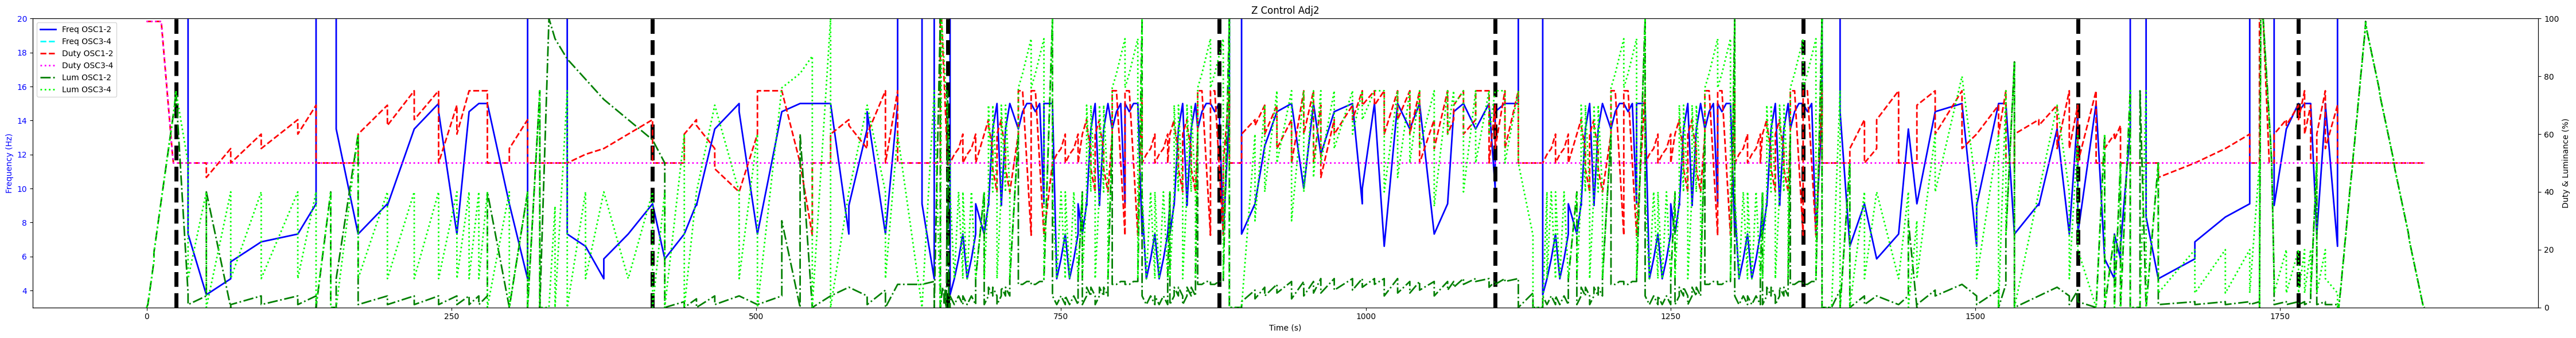

In [ ]:
import os
import matplotlib.pyplot as plt
import numpy as np

# -----------------------------------------------------------
# Basic Formatting Functions
# -----------------------------------------------------------
def format_time(total_seconds):
    """Format total seconds as hh:mm:ss.s with leading zeros."""
    minutes = int(total_seconds // 60)
    seconds = int(total_seconds % 60)
    fraction = total_seconds - int(total_seconds)
    return f"00:{minutes:02}:{seconds:02}.{int(fraction * 10)}"

def get_led_assignments():
    """
    Return unique LED assignments:
      OSC1: [1,0,0,0]
      OSC2: [0,1,0,0]
      OSC3: [0,0,1,0]
      OSC4: [0,0,0,1]
    """
    return [[1,0,0,0], [0,1,0,0], [0,0,1,0], [0,0,0,1]]

def format_stp_dual(step_duration, wave_type, freq12, duty12, lum12, freq34, duty34, lum34):
    """
    Format an STP line for dual-group sequences.
    Each parameter is a 2-element list.
    """
    led_assignments = get_led_assignments()
    blocks = []
    # OSC1 and OSC2 use the OSC12 parameters.
    for osc in range(2):
        block = (f"{wave_type},"
                 f"{freq12[0]:.2f},{freq12[1]:.2f},"
                 f"{round(duty12[0])},{round(duty12[1])},"
                 f"{','.join(map(str, led_assignments[osc]))},"
                 f"{round(lum12[0])},{round(lum12[1])}")
        blocks.append(block)
    # OSC3 and OSC4 use the OSC34 parameters.
    for osc in range(2,4):
        block = (f"{wave_type},"
                 f"{freq34[0]:.2f},{freq34[1]:.2f},"
                 f"{round(duty34[0])},{round(duty34[1])},"
                 f"{','.join(map(str, led_assignments[osc]))},"
                 f"{round(lum34[0])},{round(lum34[1])}")
        blocks.append(block)
    return f"STP\"{max(step_duration, 0.1):.1f},{','.join(blocks)}\""

def create_time_series(durations, pairs):
    """
    Given a list of step durations and corresponding [start, end] pairs,
    return a list of time points and values (linear interpolation).
    """
    times = []
    values = []
    current_time = 0
    for d, pair in zip(durations, pairs):
        times.append(current_time)
        values.append(pair[0])
        current_time += d
        times.append(current_time)
        values.append(pair[1])
    return times, values

# -----------------------------------------------------------
# Sequence Parameters for a Single Sequence
# -----------------------------------------------------------

sequence = {
  "durations": [
    # Warmup - 0:00 to 0:24
    1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
    # Segment A - 127 seconds. 0:24 to 2:31
    10, 15, 20, 25, 30, 15, 12,
    # dark phase (extended from 2 to 4.5) - 2:31 to 2:35.5
    4.5,
    # rest of Segment A - 167 seconds. 2:35.5 to 5:22.5
    18, 24, 22, 20, 15, 10, 8, 7, 18, 15, 10,
    # interim dark phase (extended from 3 to 7.5) - 5:22.5 to 5:30
    7.5,
    # Segment B - 321 seconds. 5:30 to 10:51
    5, 10, 15, 15, 20, 20, 10, 16, 10, 15, 20, 15, 20, 15, 10, 15, 15, 15, 15, 10, 20, 10, 5,
    # interim wash phase - swapped from interim dark phase of 3 seconds to wash phase of 8 seconds - 10:51 to 10:59
    1, 1, 1, 1, 1, 1, 1, 1,
    # Segment C1 - 229.1 seconds + made final step last 5 seconds (+3.2s). 10:59 to 15:48.1
    3.5, 3.5, 3.5, 3.5, 3.5, 3.5, 7, 3.5, 3.5, 3.5, 3.5, 3.5, 3.5, 7, 3.5, 3.5, 3.5, 3.5, 3.5, 3.5, 7,
    3.5, 3.5, 3.5, 3.5, 3.5, 3.5, 3.5, 3.5, 3.5, 3.5, 3.5, 3.5, 3.5, 3.5, 3.5, 3.5, 3.5, 3.5, 3.5, 3.5, 3.5,
    3.5, 3.5, 3.5, 3.5, 3.5, 3.5, 1.8, 3.5, 3.5, 3.5, 3.5, 3.5, 3.5, 1.8, 3.5, 3.5, 3.5, 3.5, 3.5, 3.5, 5,
    # interim dark phase (extended from 5 to 10) - 15:48.1 to 15:58.1
    10,
    # Peak Segment - 239 seconds. 15:58.1 to 19:57.1
    11, 8, 10, 12, 10, 8, 6, 11, 15, 8, 10, 8, 11, 10, 8, 12, 11, 5, 8, 10, 11, 5, 8, 11, 12,
    # interim dark phase (extended from 5 to 8) - 19:57.1 to 20:05.1
    8,
    # Segment C2 - 229.1 seconds + made final step last 5 seconds (+3.2s). 20:05.1 to 23:49.2
    3.5, 3.5, 3.5, 3.5, 3.5, 3.5, 7, 3.5, 3.5, 3.5, 3.5, 3.5, 3.5, 7, 3.5, 3.5, 3.5, 3.5, 3.5, 3.5, 7,
    3.5, 3.5, 3.5, 3.5, 3.5, 3.5, 3.5, 3.5, 3.5, 3.5, 3.5, 3.5, 3.5, 3.5, 3.5, 3.5, 3.5, 3.5, 3.5, 3.5, 3.5,
    3.5, 3.5, 3.5, 3.5, 3.5, 3.5, 1.8, 3.5, 3.5, 3.5, 3.5, 3.5, 3.5, 1.8, 3.5, 3.5, 3.5, 3.5, 3.5, 3.5, 5,
    # interim dark phase (extended from 3 to 7.8) - 23:49.2 to 23:57
    7.8,
    # Segment D - 245 seconds. 23:57 to 28:02
    7, 8, 12, 10, 18, 8, 7, 15, 22, 12, 18, 6, 7, 20, 15, 10, 7, 15, 7, 8, 5, 8,
    # interim dark phase (extended from 3 to 8). 28:02 to 28:10
    8,
    # Segment E - 98 seconds. 28:10 to 29:48.
    5, 10, 30, 25, 20, 8,
    # interim wash phase - swapped from interim dark phase of 2 seconds to wash phase of 12 seconds - 29:48 to 30:00
    1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
    # rest of Segment E - 52 seconds. 30:00 to 30:52
    10, 10, 5, 5, 5, 7, 10,
    # Cooldown (71 items) - 71.3 seconds. 30:52 to 32:03.3
    1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
    1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
    1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1.3
  ],
  "freqs_osc12": [
    # Warmup (24 items)
    [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60],
    [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60],
    # Segment A (18 items) + 1 dark phase
    [60, 60], [7.32, 3.75], [3.75, 4.69], [5.69, 6.86], [6.86, 7.32], [7.32, 9.1],
    [60, 60],
    [60, 60], # dark phase
    [13.5, 7.32], [7.32, 9.1], [9, 13.5], [13.5, 15], [14.52, 7.32],
    [7.32, 14.52], [14.52, 15], [15, 15], [15, 9.1], [9.1, 4.69], [60, 60],
    [60, 60], # interim dark phase
    # Segment B (23 items)
    [60, 60], [60, 60], [7.32, 6.6], [6.6, 4.69], [5.86, 7.32], [7.32, 9.1], [9.1, 5.86], [5.86, 7.32],
    [7.32, 9.1], [9, 13.5], [13.5, 15], [14.52, 7.32], [7.32, 14.52], [14.52, 15], [15, 15], [15, 15],
    [15, 7.32], [9, 13.5], [14.52, 7.32], [7.32, 15], [60, 60], [9.1, 4.69], [60, 60],
    # Interim wash phase (8 items)
    [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60],
    # Segment C1 (63 items)
    [3.75, 4.69], [4.69, 5.86], [5.86, 7.32], [7.32, 4.69], [4.69, 5.86], [5.86, 7.32], [9.1, 7.32],
    [7.32, 9.1], [9, 13.5], [13.5, 15], [15, 9.1], [9, 13.5], [13.5, 15], [15, 13.5],
    [13.5, 14.52], [14.52, 15], [15, 15], [15, 14.52], [14.52, 15], [15, 9.1], [15, 15],
    [15, 4.69], [4.69, 5.86], [5.86, 7.32], [7.32, 4.69], [4.69, 5.86], [5.86, 7.32], [9.1, 7.32],
    [7.32, 9.1], [9, 13.5], [13.5, 15], [15, 9.1], [9, 13.5], [13.5, 15], [15, 13.5],
    [13.5, 14.52], [14.52, 15], [15, 9.1], [15, 14.52], [14.52, 15], [15, 15], [15, 7.32],
    [9, 4.69], [4.69, 5.86], [5.86, 7.32], [7.32, 4.69], [4.69, 5.86], [5.86, 7.32], [7.32, 9.1],
    [7.32, 9.1], [9, 13.5], [13.5, 15], [15, 9.1], [9, 13.5], [13.5, 15], [15, 13.5],
    [13.5, 14.52], [14.52, 15], [15, 15], [15, 14.52], [14.52, 15], [15, 7.32], [7.32, 14.52],
    [60, 60], # interim dark phase
    # Peak Segment (25 items)
    [7.32, 9.1], [9.1, 12.5], [12.5, 14.52], [14.52, 15], [15, 10], [10, 15], [15, 12],
    [12, 14.52], [14.52, 15], [15, 9.1], [10, 15], [15, 6.6], [6.6, 15],
    [15, 13.5], [13.5, 15], [15, 7.32], [7.32, 9.1], [9.1, 14.52], [14.52, 15],
    [15, 13.5], [13.5, 15], [15, 10], [14.52, 15], [15, 15], [60, 60],
    [60, 60], # interim dark phase
    # Segment C2 (63 items)
    [3.75, 4.69], [4.69, 5.86], [5.86, 7.32], [7.32, 4.69], [4.69, 5.86], [5.86, 7.32], [9.1, 7.32],
    [7.32, 9.1], [9, 13.5], [13.5, 15], [15, 9.1], [9, 13.5], [13.5, 15], [15, 13.5],
    [13.5, 14.52], [14.52, 15], [15, 15], [15, 14.52], [14.52, 15], [15, 9.1], [15, 15],
    [15, 4.69], [4.69, 5.86], [5.86, 7.32], [7.32, 4.69], [4.69, 5.86], [5.86, 7.32], [9.1, 7.32],
    [7.32, 9.1], [9, 13.5], [13.5, 15], [15, 9.1], [9, 13.5], [13.5, 15], [15, 13.5],
    [13.5, 14.52], [14.52, 15], [15, 9.1], [15, 14.52], [14.52, 15], [15, 15], [15, 7.32],
    [9, 4.69], [4.69, 5.86], [5.86, 7.32], [7.32, 4.69], [4.69, 5.86], [5.86, 7.32], [7.32, 9.1],
    [7.32, 9.1], [9, 13.5], [13.5, 15], [15, 9.1], [9, 13.5], [13.5, 15], [15, 13.5],
    [13.5, 14.52], [14.52, 15], [15, 15], [15, 14.52], [14.52, 15], [15, 7.32], [7.32, 14.52],
    [60, 60], # interim dark phase
    # Segment D (22 items)
    [60, 60], [14.52, 6.6], [6.6, 9.1], [9.1, 5.86], [5.86, 7.32], [7.32, 13.5], [13.5, 9.1],
    [9.1, 14.52], [14.52, 15], [15, 6.6], [9, 15], [15, 15], [15, 7.32], [7.32, 9.1],
    [9, 13.5], [13.5, 7.32], [7.32, 14.52], [7.32, 15], [15, 5.86], [5.86, 4.69], [7.32, 5.86], [6.6, 13.5],
    [60, 60], # interim dark phase
    # Segment E (13 items total) + 1 wash phase of 12 steps
    [60, 60], [8.32, 4.69], [4.69, 5.86], [6.86, 8.32], [8.32, 9.1], [60, 60],
    # Interim wash phase (12 items)
    [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60],
    # Rest of Segment E
    [9, 13.5], [13.5, 15], [14.52, 15], [15, 15], [15, 7.32], [7.32, 14.52], [15, 6.6],
    # Cooldown (71 items)
    [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60],
    [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60],
    [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60],
    [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60],
    [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60],
    [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60]
  ],
  "duties_osc12": [
    # Warmup (24 items)
    [99, 99], [99, 99], [99, 99], [99, 99], [99, 99], [99, 99], [99, 99], [99, 99], [99, 99], [99, 99], [99, 99], [99, 99],
    [99, 94], [94, 89], [89, 84], [84, 79], [79, 74], [74, 69], [69, 64], [64, 59], [59, 54], [54, 50], [50, 50], [50, 50],
    # Segment A (18 items) + 1 dark phase
    [50, 50], [50, 50], [45, 55], [50, 60], [55, 65], [60, 70],
    [50, 50],
    [50, 50], # dark phase
    [50, 50], [60, 70], [63, 75], [65, 75], [50, 70],
    [60, 75], [75, 75], [75, 75], [50, 50], [55, 65], [50, 50],
    [50, 50], # interim dark phase
    # Segment B (23 items)
    [50, 50], [50, 50], [50, 53], [53, 55], [55, 60], [60, 65], [50, 50], [50, 50],
    [60, 65], [63, 55], [48, 40], [40, 60], [75, 75], [75, 50], [50, 25], [50, 50],
    [60, 65], [63, 55], [60, 75], [50, 75], [50, 50], [50, 50], [50, 50],
    # Interim wash phase (8 items)
    [100, 100], [100, 90], [90, 80], [80, 70], [70, 60], [60, 50], [50, 50], [50, 50],
    # Segment C1 (63 items)
    [50, 53], [53, 55], [55, 60], [50, 53], [53, 55], [55, 60], [50, 60],
    [60, 65], [63, 55], [48, 40], [60, 65], [63, 55], [48, 40], [40, 60],
    [75, 75], [75, 50], [50, 25], [75, 75], [75, 50], [50, 25], [25, 50],
    [50, 53], [53, 55], [55, 60], [50, 53], [53, 55], [55, 60], [50, 60],
    [60, 65], [63, 55], [48, 40], [60, 65], [63, 55], [48, 40], [40, 60],
    [75, 75], [75, 50], [50, 25], [75, 75], [75, 50], [50, 25], [25, 75],
    [50, 53], [53, 55], [55, 60], [50, 53], [53, 55], [55, 60], [50, 60],
    [60, 65], [63, 55], [48, 40], [60, 65], [63, 55], [48, 40], [40, 60],
    [75, 75], [75, 50], [50, 25], [75, 75], [75, 50], [50, 25], [50, 75],
    [50, 50], # interim dark phase
    # Peak Segment (25 items)
    [60, 65], [63, 70], [60, 70], [55, 65], [50, 75], [60, 75], [50, 70],
    [45, 65], [60, 70], [65, 75], [70, 75], [70, 75], [60, 75],
    [65, 75], [60, 75], [50, 65], [55, 75], [60, 65], [70, 75],
    [60, 65], [75, 75], [50, 70], [55, 75], [55, 75], [50, 50],
    [50, 50], # interim dark phase
    # Segment C2 (63 items)
    [50, 53], [53, 55], [55, 60], [50, 53], [53, 55], [55, 60], [50, 60],
    [60, 65], [63, 55], [48, 40], [60, 65], [63, 55], [48, 40], [40, 60],
    [75, 75], [75, 50], [50, 25], [75, 75], [75, 50], [50, 25], [25, 75],
    [50, 53], [53, 55], [55, 60], [50, 53], [53, 55], [55, 60], [50, 60],
    [60, 65], [63, 55], [48, 40], [60, 65], [63, 55], [48, 40], [40, 60],
    [75, 75], [75, 50], [50, 25], [75, 75], [75, 50], [50, 25], [25, 75],
    [50, 53], [53, 55], [55, 60], [50, 53], [53, 55], [55, 60], [50, 60],
    [60, 65], [63, 55], [48, 40], [60, 65], [63, 55], [48, 40], [40, 60],
    [75, 75], [75, 50], [50, 25], [75, 75], [75, 50], [50, 25], [25, 75],
    [50, 50], # interim dark phase
    # Segment D (22 items)
    [50, 50], [50, 50], [55, 65], [50, 55], [65, 75], [50, 50], [50, 50],
    [70, 75], [60, 75], [55, 60], [60, 70], [60, 75], [50, 50], [60, 65],
    [63, 70], [55, 75], [55, 70], [50, 75], [50, 50], [55, 60], [58, 63], [50, 50],
    [50, 50], # interim dark phase
    # Segment E (13 items total) + 1 wash phase of 12 steps
    [50, 50], [50, 50], [45, 50], [50, 55], [55, 60], [50, 50],
    # Interim wash phase (12 items)
    [100, 100], [100, 100], [100, 100], [100, 90], [90, 80], [80, 70], [70, 60], [60, 50], [50, 50], [50, 50], [50, 50], [50, 50],
    # Rest of Segment E
    [60, 65], [63, 70], [65, 75], [60, 70], [50, 50], [60, 75], [55, 70],
    # Cooldown (71 items)
    [50, 50], [50, 50], [50, 50], [50, 50], [50, 50], [50, 50], [50, 50], [50, 50], [50, 50], [50, 50], [50, 50], [50, 50],
    [50, 50], [50, 50], [50, 50], [50, 50], [50, 50], [50, 50], [50, 50], [50, 50], [50, 50], [50, 50], [50, 50], [50, 50],
    [50, 50], [50, 50], [50, 50], [50, 50], [50, 50], [50, 50], [50, 50], [50, 50], [50, 50], [50, 50], [50, 50], [50, 50],
    [50, 50], [50, 50], [50, 50], [50, 50], [50, 50], [50, 50], [50, 50], [50, 50], [50, 50], [50, 50], [50, 50], [50, 50],
    [50, 50], [50, 50], [50, 50], [50, 50], [50, 50], [50, 50], [50, 50], [50, 50], [50, 50], [50, 50], [50, 50], [50, 50],
    [50, 50], [50, 50], [50, 50], [50, 50], [50, 50], [50, 50], [50, 50], [50, 50], [50, 50], [50, 50], [50, 50]
  ],
  "lums_osc34": [
    # Warmup (24 items)
    [0, 1], [1, 4], [4, 7], [7, 10], [10, 13], [13, 16], [19, 22], [22, 25], [25, 28], [28, 31], [31, 34], [34, 37],
    [37, 40], [40, 43], [43, 46], [46, 49], [49, 52], [52, 55], [55, 58], [58, 61], [61, 64], [64, 67], [67, 70], [70, 75],
    # Segment A (18 items) + 1 dark phase
    [75, 50],
    [10, 40], [0, 40], [10, 40], [10, 40], [10, 40], [1, 40],
    [0, 0], # dark phase
    [0, 60],
    [10, 40], [10, 40], [10, 40], [10, 40], [10, 40], [10, 40], [10, 40], [0, 40],
    [0, 40],
    [0, 75],
    [0, 0], # interim dark phase
    # Segment B (23 items)
    [0, 35], [0, 75],
    [0, 40], [10, 40], [40, 10], [10, 40], [0, 40], [0, 60],
    [0, 40], [40, 70], [70, 40], [10, 60], [0, 76], [76, 81], [81, 87], [0, 100],
    [0, 40], [40, 70], [70, 40], [10, 60], [60, 0],
    [0, 75], [75, 0],
    # Interim wash phase (8 items)
    [0, 100], [100, 93], [93, 86], [86, 79], [79, 72], [72, 65], [65, 58], [58, 50],
    # Segment C1 (63 items)
    [40, 10], [10, 40], [40, 10], [40, 10], [10, 40], [40, 10], [10, 40],
    [10, 40], [70, 40], [70, 40], [10, 40], [70, 40], [70, 40], [10, 60],
    [76, 81], [81, 87], [87, 93], [76, 81], [81, 87], [87, 93], [10, 100],
    [40, 10], [10, 40], [40, 10], [40, 10], [10, 40], [40, 10], [10, 40],
    [10, 40], [70, 40], [70, 40], [10, 40], [70, 40], [70, 40], [10, 60],
    [76, 81], [81, 87], [87, 93], [76, 81], [81, 87], [87, 93], [10, 100],
    [40, 10], [10, 40], [40, 10], [40, 10], [10, 40], [40, 10], [10, 40],
    [10, 40], [70, 40], [70, 40], [10, 40], [70, 40], [70, 40], [10, 60],
    [76, 81], [81, 87], [87, 93], [76, 81], [81, 87], [87, 93], [10, 100],
    [0, 0], # interim dark phase
    # Peak Segment (25 items)
    [0, 60], [30, 70], [40, 75], [50, 75], [30, 75], [40, 75], [45, 75],
    [50, 75], [55, 75], [60, 75], [65, 75], [75, 75], [40, 75],
    [45, 75], [50, 75], [55, 75], [35, 75], [60, 75], [70, 75],
    [40, 75], [50, 75], [60, 75], [75, 75], [50, 75], [50, 25],
    [0, 0], # interim dark phase
    # Segment C2 (63 items)
    [0, 40], [10, 40], [40, 10], [40, 10], [10, 40], [40, 10], [10, 40],
    [10, 40], [70, 40], [70, 40], [10, 40], [70, 40], [70, 40], [10, 60],
    [76, 81], [81, 87], [87, 93], [76, 81], [81, 87], [87, 93], [10, 100],
    [40, 10], [10, 40], [40, 10], [40, 10], [10, 40], [40, 10], [10, 40],
    [10, 40], [70, 40], [70, 40], [10, 40], [70, 40], [70, 40], [10, 60],
    [76, 81], [81, 87], [87, 93], [76, 81], [81, 87], [87, 93], [10, 100],
    [40, 10], [10, 40], [40, 10], [40, 10], [10, 40], [40, 10], [10, 40],
    [10, 40], [70, 40], [70, 40], [10, 40], [70, 40], [70, 40], [10, 60],
    [76, 81], [81, 87], [87, 93], [76, 81], [81, 87], [87, 93], [10, 100],
    [0, 0], # interim dark phase
    # Segment D (22 items)
    [0, 75], [0, 50], [0, 40], [10, 40], [40, 10], [10, 40], [0, 30],
    [10, 60], [40, 80], [80, 40], [10, 60], [0, 75], [25, 85],
    [0, 40], [40, 70], [70, 40], [10, 60], [20, 0], [0, 60],
    [0, 25], [0, 50], [0, 75],
    [0, 0], # interim dark phase
    # Segment E (13 items total) + 1 wash phase of 12 steps
    [0, 75],
    [0, 50], [5, 20], [5, 20], [5, 20], [5, 50],
    # Interim wash phase (12 items)
    [0, 100], [100, 100], [100, 100], [100, 93], [93, 86], [86, 79], [79, 72], [72, 65], [65, 58], [58, 50], [50, 30], [30, 10],
    # Rest of Segment E
    [5, 20], [5, 20], [5, 20], [5, 20], [5, 50], [5, 20],
    [10, 5],
    # Cooldown (71 items)
    [0, 1], [0, 4], [4, 8], [8, 13], [13, 17], [17, 22], [22, 26],
    [26, 31], [31, 35], [35, 40], [40, 44], [44, 48], [48, 53], [53, 57],
    [57, 62], [62, 66], [66, 71], [71, 75], [75, 80], [80, 84], [84, 89],
    [89, 93], [93, 98], [99, 96], [96, 94], [94, 92], [92, 90], [90, 88],
    [88, 86], [86, 84], [84, 82], [82, 80], [80, 78], [78, 76], [76, 73],
    [73, 71], [71, 69], [69, 67], [67, 65], [65, 63], [63, 61], [61, 59],
    [59, 57], [57, 55], [55, 53], [53, 51], [51, 48], [48, 46], [46, 44],
    [44, 42], [42, 40], [40, 38], [38, 36], [36, 34], [34, 32], [32, 30],
    [30, 28], [28, 26], [26, 23], [23, 21], [21, 19], [19, 17], [17, 15],
    [15, 13], [13, 11], [11, 9], [9, 7], [7, 5], [5, 3], [3, 1],
    [1, 0]
  ],
  "freqs_osc34": [
    # Warmup (24 items)
    [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60],
    [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60],
    # Segment A (18 items) + 1 dark phase
    [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60],
    [60, 60], # dark phase
    [60, 60], [60, 60],
    [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60],
    [60, 60], # interim dark phase
    # Segment B (23 items)
    [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60],
    [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60],
    [60, 60], [60, 60], [60, 60], [60, 60], [60, 60],
    # Interim wash phsae (8 items)
    [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60],
    # Segment C1 (63 items)
    [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60],
    [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60],
    [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60],
    [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60],
    [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60],
    [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60],
    [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60],
    [60, 60], # interim dark phase
    # Peak Segment (25 items)
    [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60],
    [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60],
    [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60],
    [60, 60], # interim dark phase
    # Segment C2 (63 items)
    [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60],
    [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60],
    [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60],
    [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60],
    [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60],
    [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60],
    [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60],
    [60, 60], # interim dark phase
    # Segment D (22 items)
    [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60],
    [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60],
    [60, 60], [60, 60], [60, 60], [60, 60],
    [60, 60], # interim dark phase
    # Segment E (13 items total) + 1 wash phase of 12 steps
    [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60],
    # Interim wash phase (12 items)
    [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60],
    # Rest of Segment E
    [60, 60], [60, 60], [60, 60],
    [60, 60], [60, 60], [60, 60], [60, 60],
    # Cooldown (71 items)
    [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60],
    [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60],
    [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60],
    [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60],
    [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60],
    [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60], [60, 60]
  ],
  "duties_osc34": [
    # All segments: each entry is [50,50] except for the initial wash ramp
    # Warmup (24 items)
    [99, 99], [99, 99], [99, 99], [99, 99], [99, 99], [99, 99], [99, 99], [99, 99], [99, 99], [99, 99], [99, 99], [99, 99],
    [99, 94], [94, 89], [89, 84], [84, 79], [79, 74], [74, 69], [69, 64], [64, 59], [59, 54], [54, 50], [50, 50], [50, 50],
    # Segment A (18 items) + 1 dark phase
    [50, 50], [50, 50], [50, 50], [50, 50], [50, 50], [50, 50], [50, 50],
    [50, 50], # dark phase
    [50, 50], [50, 50],
    [50, 50], [50, 50], [50, 50], [50, 50], [50, 50], [50, 50], [50, 50], [50, 50], [50, 50],
    [50, 50], # interim dark phase
    # Segment B (23 items)
    [50, 50], [50, 50], [50, 50], [50, 50], [50, 50], [50, 50], [50, 50], [50, 50], [50, 50],
    [50, 50], [50, 50], [50, 50], [50, 50], [50, 50], [50, 50], [50, 50], [50, 50], [50, 50],
    [50, 50], [50, 50], [50, 50], [50, 50], [50, 50],
    # Interim wash phase (8 items)
    [50, 50], [50, 50], [50, 50], [50, 50], [50, 50], [50, 50], [50, 50], [50, 50],
    # Segment C1 (63 items)
    [50, 50], [50, 50], [50, 50], [50, 50], [50, 50], [50, 50], [50, 50], [50, 50], [50, 50],
    [50, 50], [50, 50], [50, 50], [50, 50], [50, 50], [50, 50], [50, 50], [50, 50], [50, 50],
    [50, 50], [50, 50], [50, 50], [50, 50], [50, 50], [50, 50], [50, 50], [50, 50], [50, 50],
    [50, 50], [50, 50], [50, 50], [50, 50], [50, 50], [50, 50], [50, 50], [50, 50], [50, 50],
    [50, 50], [50, 50], [50, 50], [50, 50], [50, 50], [50, 50], [50, 50], [50, 50], [50, 50],
    [50, 50], [50, 50], [50, 50], [50, 50], [50, 50], [50, 50], [50, 50], [50, 50], [50, 50],
    [50, 50], [50, 50], [50, 50], [50, 50], [50, 50], [50, 50], [50, 50], [50, 50], [50, 50],
    [50, 50], # interim dark phase
    # Peak Segment (25 items)
    [50, 50], [50, 50], [50, 50], [50, 50], [50, 50], [50, 50], [50, 50], [50, 50], [50, 50],
    [50, 50], [50, 50], [50, 50], [50, 50], [50, 50], [50, 50], [50, 50], [50, 50], [50, 50],
    [50, 50], [50, 50], [50, 50], [50, 50], [50, 50], [50, 50], [50, 50],
    [50, 50], # interim dark phase
    # Segment C2 (63 items)
    [50, 50], [50, 50], [50, 50], [50, 50], [50, 50], [50, 50], [50, 50], [50, 50], [50, 50],
    [50, 50], [50, 50], [50, 50], [50, 50], [50, 50], [50, 50], [50, 50], [50, 50], [50, 50],
    [50, 50], [50, 50], [50, 50], [50, 50], [50, 50], [50, 50], [50, 50], [50, 50], [50, 50],
    [50, 50], [50, 50], [50, 50], [50, 50], [50, 50], [50, 50], [50, 50], [50, 50], [50, 50],
    [50, 50], [50, 50], [50, 50], [50, 50], [50, 50], [50, 50], [50, 50], [50, 50], [50, 50],
    [50, 50], [50, 50], [50, 50], [50, 50], [50, 50], [50, 50], [50, 50], [50, 50], [50, 50],
    [50, 50], [50, 50], [50, 50], [50, 50], [50, 50], [50, 50], [50, 50], [50, 50], [50, 50],
    [50, 50], # interim dark phase
    # Segment D (22 items)
    [50, 50], [50, 50], [50, 50], [50, 50], [50, 50], [50, 50], [50, 50], [50, 50], [50, 50],
    [50, 50], [50, 50], [50, 50], [50, 50], [50, 50], [50, 50], [50, 50], [50, 50], [50, 50],
    [50, 50], [50, 50], [50, 50], [50, 50],
    [50, 50], # interim dark phase
    # Segment E (13 items) + 1 wash phase of 12 steps
    [50, 50], [50, 50], [50, 50], [50, 50], [50, 50], [50, 50],
    # Interim wash phase (12 items)
    [50, 50], [50, 50], [50, 50], [50, 50], [50, 50], [50, 50], [50, 50], [50, 50], [50, 50], [50, 50], [50, 50], [50, 50],
    # Rest of Segment E
    [50, 50], [50, 50], [50, 50],
    [50, 50], [50, 50], [50, 50], [50, 50],
    # Cooldown (71 items)
    [50, 50], [50, 50], [50, 50], [50, 50], [50, 50], [50, 50], [50, 50], [50, 50], [50, 50], [50, 50], [50, 50], [50, 50],
    [50, 50], [50, 50], [50, 50], [50, 50], [50, 50], [50, 50], [50, 50], [50, 50], [50, 50], [50, 50], [50, 50], [50, 50],
    [50, 50], [50, 50], [50, 50], [50, 50], [50, 50], [50, 50], [50, 50], [50, 50], [50, 50], [50, 50], [50, 50], [50, 50],
    [50, 50], [50, 50], [50, 50], [50, 50], [50, 50], [50, 50], [50, 50], [50, 50], [50, 50], [50, 50], [50, 50], [50, 50],
    [50, 50], [50, 50], [50, 50], [50, 50], [50, 50], [50, 50], [50, 50], [50, 50], [50, 50], [50, 50], [50, 50], [50, 50],
    [50, 50], [50, 50], [50, 50], [50, 50], [50, 50], [50, 50], [50, 50], [50, 50], [50, 50], [50, 50], [50, 50]
  ],
  "lums_osc12": [
    # Warmup (24 items)
    [0, 1], [1, 4], [4, 7], [7, 10], [10, 13], [13, 16], [19, 22], [22, 25], [25, 28], [28, 31], [31, 34], [34, 37],
    [37, 40], [40, 43], [43, 46], [46, 49], [49, 52], [52, 55], [55, 58], [58, 61], [61, 64], [64, 67], [67, 70], [70, 75],
    # Segment A (18 items) + 1 dark phase
    [75, 5],
    [1, 4], [40, 0], [1, 4], [1, 4], [1, 4], [0, 40],
    [0, 0], # dark phase
    [10, 60],
    [1, 4], [1, 4], [1, 4], [1, 4], [1, 4], [1, 4], [1, 4], [40, 0],
    [0, 40],
    [0, 75],
    # Interim wash phase (8 items)
    [0, 100], [100, 93], [93, 86], [86, 79], [79, 72], [72, 65], [65, 58], [58, 50],
    # Segment B (23 items)
    [0, 2], [0, 3],
    [0, 4], [1, 4], [4, 1], [1, 4], [30, 0], [60, 0],
    [0, 4], [4, 7], [7, 4], [1, 6], [0, 8], [8, 8], [8, 9], [0, 100],
    [0, 4], [4, 7], [7, 4], [1, 6], [2, 0],
    [0, 75], [75, 0],
    [0, 0], # interim dark phase
    # Segment C1 (63 items)
    [4, 1], [1, 4], [4, 1], [4, 1], [1, 4], [4, 1], [10, 40],
    [1, 4], [7, 4], [7, 4], [1, 4], [7, 4], [7, 4], [10, 60],
    [8, 8], [8, 9], [9, 9], [8, 8], [8, 9], [9, 9], [10, 100],
    [4, 1], [1, 4], [4, 1], [4, 1], [1, 4], [4, 1], [10, 40],
    [1, 4], [7, 4], [7, 4], [1, 4], [7, 4], [7, 4], [10, 60],
    [8, 8], [8, 9], [9, 9], [8, 8], [8, 9], [9, 9], [10, 100],
    [4, 1], [1, 4], [4, 1], [4, 1], [1, 4], [4, 1], [10, 40],
    [1, 4], [7, 4], [7, 4], [1, 4], [7, 4], [7, 4], [10, 60],
    [8, 8], [8, 9], [9, 9], [8, 8], [8, 9], [9, 9], [10, 100],
    [0, 0], # interim dark phase
    # Peak Segment (25 items)
    [2, 6], [3, 7], [4, 8], [5, 9], [3, 9], [4, 9], [5, 10],
    [5, 10], [6, 10], [6, 10], [7, 10], [8, 10], [4, 10],
    [5, 9], [5, 9], [6, 9], [4, 9], [6, 9], [7, 10],
    [8, 10], [9, 10], [7, 9], [8, 10], [9, 10], [0, 5],
    [0, 0], # dark phase
    # Segment C2 (63 items)
    [4, 1], [1, 4], [4, 1], [4, 1], [1, 4], [4, 1], [10, 40],
    [1, 4], [7, 4], [7, 4], [1, 4], [7, 4], [7, 4], [10, 60],
    [8, 8], [8, 9], [9, 9], [8, 8], [8, 9], [9, 9], [10, 100],
    [4, 1], [1, 4], [4, 1], [4, 1], [1, 4], [4, 1], [10, 40],
    [1, 4], [7, 4], [7, 4], [1, 4], [7, 4], [7, 4], [10, 60],
    [8, 8], [8, 9], [9, 9], [8, 8], [8, 9], [9, 9], [10, 100],
    [4, 1], [1, 4], [4, 1], [4, 1], [1, 4], [4, 1], [10, 40],
    [1, 4], [7, 4], [7, 4], [1, 4], [7, 4], [7, 4], [10, 60],
    [8, 8], [8, 9], [9, 9], [8, 8], [8, 9], [9, 9], [10, 100],
    [0, 0], # interim dark phase
    # Segment D (22 items)
    [0, 6], [0, 50], [0, 4], [1, 4], [4, 1], [1, 4], [30, 0],
    [1, 6], [4, 8], [8, 4], [1, 6], [0, 8], [25, 85],
    [0, 4], [4, 7], [7, 4], [1, 6], [2, 0], [0, 60],
    [0, 25], [0, 50], [0, 75],
    [0, 0], # interim dark phase
    # Segment E (13 items total) + 1 wash phase of 12 steps
    [75, 0],
    [0, 50], [1, 2], [1, 2], [1, 2], [1, 2],
    # Interim wash phase (12 items)
    [0, 100], [100, 100], [100, 100], [100, 93], [93, 86], [86, 79], [79, 72], [72, 65], [65, 58], [58, 50], [50, 30], [30, 10],
    # Rest of Segment E
    [1, 2], [1, 2], [1, 2], [1, 2], [5, 50], [1, 2],
    [1, 1],
    # Cooldown (71 items)
    [0, 1], [0, 4], [4, 8], [8, 13], [13, 17], [17, 22], [22, 26],
    [26, 31], [31, 35], [35, 40], [40, 44], [44, 48], [48, 53], [53, 57],
    [57, 62], [62, 66], [66, 71], [71, 75], [75, 80], [80, 84], [84, 89],
    [89, 93], [93, 98], [99, 96], [96, 94], [94, 92], [92, 90], [90, 88],
    [88, 86], [86, 84], [84, 82], [82, 80], [80, 78], [78, 76], [76, 73],
    [73, 71], [71, 69], [69, 67], [67, 65], [65, 63], [63, 61], [61, 59],
    [59, 57], [57, 55], [55, 53], [53, 51], [51, 48], [48, 46], [46, 44],
    [44, 42], [42, 40], [40, 38], [38, 36], [36, 34], [34, 32], [32, 30],
    [30, 28], [28, 26], [26, 23], [23, 21], [21, 19], [19, 17], [17, 15],
    [15, 13], [13, 11], [11, 9], [9, 7], [7, 5], [5, 3], [3, 1],
    [1, 0]
  ]
}

# -----------------------------------------------------------
# STP File Generation Function for a Single Sequence
# -----------------------------------------------------------
def generate_stp_file(seq_name, params, output_folder="stp_sequence"):
    durations = params["durations"]
    total_duration = sum(durations)
    lines = []
    lines.append(f'TIM"{format_time(total_duration)}"')
    lines.append(f'DUR"{total_duration:.1f}"')
    wave_type = 1  # square wave

    # This is a dual-group sequence:
    for i, d in enumerate(durations):
        freq12 = params["freqs_osc12"][i]
        duty12 = params["duties_osc12"][i]
        lum12  = params["lums_osc12"][i]
        freq34 = params["freqs_osc34"][i]
        duty34 = params["duties_osc34"][i]
        lum34  = params["lums_osc34"][i]
        line = format_stp_dual(d, wave_type, freq12, duty12, lum12, freq34, duty34, lum34)
        lines.append(line)
    os.makedirs(output_folder, exist_ok=True)
    filepath = os.path.join(output_folder, seq_name + ".txt")
    with open(filepath, "w", newline="\r\n", encoding="utf-8") as f:
        f.write("\r\n".join(lines))
    print(f"Generated STP file: {filepath}")

# -----------------------------------------------------------
# Plot Generation Function for a Single Sequence
# -----------------------------------------------------------
def generate_plot(seq_name, params, output_folder="plots"):
    durations = params["durations"]
    # Create time series for OSC1-2 and OSC3-4:
    t_freq12, freq_vals12 = create_time_series(durations, params["freqs_osc12"])
    t_duty12, duty_vals12 = create_time_series(durations, params["duties_osc12"])
    t_lum12, lum_vals12   = create_time_series(durations, params["lums_osc12"])
    t_freq34, freq_vals34 = create_time_series(durations, params["freqs_osc34"])
    t_duty34, duty_vals34 = create_time_series(durations, params["duties_osc34"])
    t_lum34, lum_vals34   = create_time_series(durations, params["lums_osc34"])

    fig, ax_left = plt.subplots(figsize=(45,6))
    ax_right = ax_left.twinx()

    ax_left.plot(t_freq12, freq_vals12, label="Freq OSC1-2", color="blue", linewidth=2)
    ax_left.plot(t_freq34, freq_vals34, label="Freq OSC3-4", color="cyan", linestyle="--", linewidth=2)
    ax_right.plot(t_duty12, duty_vals12, label="Duty OSC1-2", color="red", linestyle="--", linewidth=2)
    ax_right.plot(t_duty34, duty_vals34, label="Duty OSC3-4", color="magenta", linestyle=":", linewidth=2)
    ax_right.plot(t_lum12, lum_vals12, label="Lum OSC1-2", color="green", linestyle="-.", linewidth=2)
    ax_right.plot(t_lum34, lum_vals34, label="Lum OSC3-4", color="lime", linestyle=":", linewidth=2)

    ax_left.set_xlabel("Time (s)")
    ax_left.set_ylabel("Frequency (Hz)", color="blue")
    ax_right.set_ylabel("Duty & Luminance (%)", color="black")
    ax_left.tick_params(axis="y", labelcolor="blue")
    ax_right.tick_params(axis="y", labelcolor="black")
    ax_left.set_ylim(3, 20)
    ax_right.set_ylim(0, 100)
    ax_left.set_title(seq_name.replace("_", " ").title())

    lines_left, labels_left = ax_left.get_legend_handles_labels()
    lines_right, labels_right = ax_right.get_legend_handles_labels()
    ax_left.legend(lines_left + lines_right, labels_left + labels_right, loc="upper left")

    os.makedirs(output_folder, exist_ok=True)
    plot_path = os.path.join(output_folder, seq_name + "_plot.png")
    # Define segment lengths (number of durations in each segment)
    seg_lengths = [24, 26, 23, 63, 25, 63, 22, 26, 71]

    # Compute cumulative boundaries (in terms of the number of durations)
    cum_indices = np.cumsum(seg_lengths)

    # Compute cumulative time from durations
    cumulative_time = np.cumsum(durations)

# Add vertical lines at each segment boundary (except the final boundary)
    for boundary_index in cum_indices[:-1]:
        boundary_time = cumulative_time[boundary_index - 1]  # End time of the segment
        ax_left.axvline(x=boundary_time, color="black", linestyle="--", linewidth=5)
    fig.tight_layout()
    plt.savefig(plot_path)

    print(f"Saved plot: {plot_path}")

# -----------------------------------------------------------
# Main Routine
# -----------------------------------------------------------
def main():
    seq_name = "z_control_adj2"
    generate_stp_file(seq_name, sequence)
    generate_plot(seq_name, sequence)

if __name__ == "__main__":
    main()